# 🚨 CRITICAL: DATA LEAKAGE PREVENTION & AUDIT

**PRODUCTION-READY DATA ENGINEERING PIPELINE**

This section performs comprehensive data leakage detection and prevention.

## ⚠️ LEAKAGE ISSUES IDENTIFIED:

1. **PS4 (Points Tally)**: Using `wins`, `draws`, `losses` to predict `total_points = wins×3 + draws×1`
2. **PS5 (Match Result)**: Potential post-match features leading to perfect predictions

## MANDATORY FIXES:

- Remove formula-based features
- Detect and remove high-correlation features (>0.95)
- Validate cleaned datasets
- Generate audit reports

In [ ]:
"""
PRODUCTION DATA LEAKAGE AUDIT SYSTEM
=====================================
Comprehensive leakage detection across all problem statements
"""

import pandas as pd
import numpy as np
from pathlib import Path
import json
from datetime import datetime

print("="*100)
print(" " * 30 + "🚨 CRITICAL: DATA LEAKAGE AUDIT")
print("="*100)

# Audit results storage
audit_results = {
    'timestamp': datetime.now().isoformat(),
    'problems': {}
}

def comprehensive_leakage_audit(df, target_col, problem_name, formula_components=None):
    """
    Comprehensive data leakage detection
    
    Args:
        df: DataFrame to audit
        target_col: Target column name
        problem_name: Descriptive name
        formula_components: List of columns that mathematically create the target
    
    Returns:
        Dict with leakage findings and columns to remove
    """
    print(f"\n{'='*100}")
    print(f"AUDITING: {problem_name}")
    print(f"{'='*100}")
    print(f"Dataset shape: {df.shape}")
    print(f"Target column: '{target_col}'")
    
    findings = {
        'problem': problem_name,
        'original_shape': df.shape,
        'target_column': target_col,
        'leakage_detected': False,
        'leakage_categories': {},
        'columns_to_remove': []
    }
    
    # CATEGORY 1: Formula-based leakage (highest priority)
    print(f"\n{'─'*100}")
    print("1️⃣  CHECKING FOR FORMULA-BASED LEAKAGE...")
    print(f"{'─'*100}")
    
    if formula_components:
        present_components = [col for col in formula_components if col in df.columns]
        if present_components:
            print(f"\n   🚨 CRITICAL LEAKAGE DETECTED!")
            print(f"   ❌ Target '{target_col}' is mathematically derived from: {formula_components}")
            print(f"   ❌ Found in dataset: {present_components}")
            print(f"\n   IMPACT: Model can achieve R²/F1 = 1.0 using these features!")
            print(f"   ACTION: MUST REMOVE: {present_components}")
            
            findings['leakage_detected'] = True
            findings['leakage_categories']['formula_based'] = present_components
            findings['columns_to_remove'].extend(present_components)
        else:
            print("   ✅ No formula components found in dataset")
    
    # CATEGORY 2: Perfect/near-perfect correlation
    print(f"\n{'─'*100}")
    print("2️⃣  CHECKING FOR CORRELATION-BASED LEAKAGE...")
    print(f"{'─'*100}")
    
    # Get feature columns
    exclude_patterns = ['target_', 'season', 'team', 'player', 'date', 'home_team', 'away_team', 'unnamed']
    feature_cols = [c for c in df.columns 
                   if c != target_col 
                   and not any(pat in c.lower() for pat in exclude_patterns)
                   and df[c].dtype in ['float64', 'int64']]
    
    if len(feature_cols) > 0:
        print(f"   Analyzing {len(feature_cols)} numeric features...")
        
        try:
            # Calculate correlations
            corr_data = df[feature_cols + [target_col]].copy()
            corr_with_target = corr_data.corr()[target_col].drop(target_col)
            
            # Perfect correlation (>0.95)
            perfect_corr = corr_with_target[abs(corr_with_target) > 0.95]
            high_corr = corr_with_target[(abs(corr_with_target) > 0.85) & (abs(corr_with_target) <= 0.95)]
            
            if len(perfect_corr) > 0:
                print(f"\n   🚨 FOUND {len(perfect_corr)} FEATURES WITH NEAR-PERFECT CORRELATION (>0.95):")
                for feat, corr_val in perfect_corr.items():
                    print(f"      ❌ {feat:50s} → {corr_val:+.6f}")
                
                findings['leakage_detected'] = True
                findings['leakage_categories']['perfect_correlation'] = {
                    str(k): float(v) for k, v in perfect_corr.items()
                }
                findings['columns_to_remove'].extend(perfect_corr.index.tolist())
            else:
                print(f"   ✅ No perfect correlations found")
            
            if len(high_corr) > 0:
                print(f"\n   ⚠️  FOUND {len(high_corr)} FEATURES WITH HIGH CORRELATION (0.85-0.95):")
                for feat, corr_val in high_corr.items():
                    print(f"      ⚠️  {feat:50s} → {corr_val:+.6f}")
                
                findings['leakage_categories']['high_correlation'] = {
                    str(k): float(v) for k, v in high_corr.items()
                }
            
            # Report max correlation for remaining features
            remaining = corr_with_target[~corr_with_target.index.isin(findings['columns_to_remove'])]
            if len(remaining) > 0:
                max_corr = abs(remaining).max()
                max_feat = abs(remaining).idxmax()
                print(f"\n   ℹ️  Maximum correlation among remaining features:")
                print(f"      {max_feat}: {remaining[max_feat]:+.4f}")
                
        except Exception as e:
            print(f"   ⚠️  Could not calculate correlations: {e}")
    else:
        print("   ℹ️  No numeric features to check")
    
    # CATEGORY 3: Target-derived features
    print(f"\n{'─'*100}")
    print("3️⃣  CHECKING FOR TARGET-DERIVED FEATURES...")
    print(f"{'─'*100}")
    
    target_patterns = ['result_', 'outcome_', 'winner_', 'final_']
    target_derived = [col for col in df.columns 
                     if any(pat in col.lower() for pat in target_patterns)
                     and col != target_col
                     and not col.startswith('target_')]
    
    if target_derived:
        print(f"   🚨 FOUND {len(target_derived)} POTENTIALLY TARGET-DERIVED FEATURES:")
        for feat in target_derived:
            print(f"      ⚠️  {feat}")
        
        findings['leakage_detected'] = True
        findings['leakage_categories']['target_derived'] = target_derived
        findings['columns_to_remove'].extend(target_derived)
    else:
        print("   ✅ No target-derived feature patterns detected")
    
    # Summary
    findings['columns_to_remove'] = list(set(findings['columns_to_remove']))  # Remove duplicates
    
    print(f"\n{'='*100}")
    print(f"AUDIT SUMMARY: {problem_name}")
    print(f"{'='*100}")
    print(f"Leakage Detected: {'YES 🚨' if findings['leakage_detected'] else 'NO ✅'}")
    print(f"Total Columns to Remove: {len(findings['columns_to_remove'])}")
    if findings['columns_to_remove']:
        print(f"\nColumns flagged for removal:")
        for col in findings['columns_to_remove']:
            print(f"  ❌ {col}")
    
    return findings

# Store for later use
audit_results_list = []

print(f"\n\n{'#'*100}")
print(f"{'#'*100}")
print(f"##{' '*44}STARTING AUDIT{' '*44}##")
print(f"{'#'*100}")
print(f"{'#'*100}")

In [ ]:
"""
AUDIT PS4: POINTS TALLY - CRITICAL LEAKAGE EXPECTED
"""

print("\n" + "🔍 "*50)

# Load current PS4 dataset
ps4_path = FINAL_DATA_DIR / 'points_tally' / 'points_tally_data.csv'
if ps4_path.exists():
    df_ps4_audit = pd.read_csv(ps4_path)
    
    # Calculate target if not present
    if 'total_points' not in df_ps4_audit.columns:
        if 'wins' in df_ps4_audit.columns and 'draws' in df_ps4_audit.columns:
            df_ps4_audit['total_points'] = df_ps4_audit['wins'] * 3 + df_ps4_audit['draws']
            print("✓ Calculated total_points from wins/draws for audit")
    
    # Define formula components (THIS IS THE LEAKAGE!)
    formula_components_ps4 = ['wins', 'draws', 'losses', 'points']
    
    # Run audit
    findings_ps4 = comprehensive_leakage_audit(
        df=df_ps4_audit,
        target_col='total_points',
        problem_name='PS4: Points Tally',
        formula_components=formula_components_ps4
    )
    
    audit_results['problems']['PS4_points_tally'] = findings_ps4
    audit_results_list.append(findings_ps4)
    
else:
    print(f"❌ PS4 dataset not found at: {ps4_path}")
    findings_ps4 = None

In [ ]:
"""
AUDIT PS5: MATCH RESULT - CHECK FOR POST-MATCH LEAKAGE
"""

print("\n" + "🔍 "*50)

# Load current PS5/Match Result dataset
ps5_path = FINAL_DATA_DIR / 'match_result' / 'match_result_data.csv'
if ps5_path.exists():
    df_ps5_audit = pd.read_csv(ps5_path)
    df_ps5_audit.columns = df_ps5_audit.columns.str.lower().str.strip()
    
    # The target should be derived from fthg/ftag
    # We don't pass formula_components here since fthg/ftag are the actual values we want to predict
    # But we check for correlation
    
    findings_ps5 = comprehensive_leakage_audit(
        df=df_ps5_audit,
        target_col='fthg',  # Check one of the goal columns
        problem_name='PS5: Match Result (Home Goals)',
        formula_components=None
    )
    
    audit_results['problems']['PS5_match_result'] = findings_ps5
    audit_results_list.append(findings_ps5)
    
else:
    print(f"❌ PS5 dataset not found at: {ps5_path}")
    findings_ps5 = None

In [ ]:
"""
AUDIT PS2: MATCH WINNER - CHECK FOR LEAKAGE
"""

print("\n" + "🔍 "*50)

ps2_path = FINAL_DATA_DIR / 'match_winner' / 'match_winner_data.csv'
if ps2_path.exists():
    df_ps2_audit = pd.read_csv(ps2_path)
    
    if 'target' in df_ps2_audit.columns:
        findings_ps2 = comprehensive_leakage_audit(
            df=df_ps2_audit,
            target_col='target',
            problem_name='PS2: Match Winner',
            formula_components=None
        )
        
        audit_results['problems']['PS2_match_winner'] = findings_ps2
        audit_results_list.append(findings_ps2)
    else:
        print("⚠️  PS2 dataset missing 'target' column")
        findings_ps2 = None
else:
    print(f"❌ PS2 dataset not found at: {ps2_path}")
    findings_ps2 = None

In [ ]:
"""
AUDIT PS1, PS3: LEAGUE WINNER & TOP SCORER
"""

print("\n" + "🔍 "*50)

# PS1: League Winner
ps1_path = FINAL_DATA_DIR / 'league_winner' / 'league_winner_data.csv'
if ps1_path.exists():
    df_ps1_audit = pd.read_csv(ps1_path)
    
    if 'target_champion' in df_ps1_audit.columns:
        findings_ps1 = comprehensive_leakage_audit(
            df=df_ps1_audit,
            target_col='target_champion',
            problem_name='PS1: League Winner',
            formula_components=None
        )
        
        audit_results['problems']['PS1_league_winner'] = findings_ps1
        audit_results_list.append(findings_ps1)
    else:
        print("⚠️  PS1 dataset missing 'target_champion' column")
        findings_ps1 = None
else:
    print(f"❌ PS1 dataset not found at: {ps1_path}")
    findings_ps1 = None

print("\n" + "🔍 "*50)

# PS3: Top Scorer
ps3_path = FINAL_DATA_DIR / 'top_scorer' / 'top_scorer_data.csv'
if ps3_path.exists():
    df_ps3_audit = pd.read_csv(ps3_path)
    
    if 'goals' in df_ps3_audit.columns:
        # Check for goal-derived features
        goal_derived = ['goals_per_90', 'goals_+_assists', 'non_penalty_goals', 
                       'goals_+_assists_per_90', 'non_penalty_goals_per_90']
        
        findings_ps3 = comprehensive_leakage_audit(
            df=df_ps3_audit,
            target_col='goals',
            problem_name='PS3: Top Scorer',
            formula_components=goal_derived  # These are derived from goals!
        )
        
        audit_results['problems']['PS3_top_scorer'] = findings_ps3
        audit_results_list.append(findings_ps3)
    else:
        print("⚠️  PS3 dataset missing 'goals' column")
        findings_ps3 = None
else:
    print(f"❌ PS3 dataset not found at: {ps3_path}")
    findings_ps3 = None

In [ ]:
"""
GENERATE COMPREHENSIVE AUDIT REPORT
"""

print("\n\n" + "="*100)
print(" " * 35 + "📊 AUDIT REPORT SUMMARY")
print("="*100)

total_problems = len(audit_results_list)
problems_with_leakage = sum(1 for r in audit_results_list if r['leakage_detected'])

print(f"\n📋 Problems Audited: {total_problems}")
print(f"🚨 Problems with Leakage: {problems_with_leakage}")
print(f"✅ Clean Problems: {total_problems - problems_with_leakage}")

if problems_with_leakage > 0:
    print(f"\n{'='*100}")
    print("⚠️  CRITICAL: DATA LEAKAGE DETECTED IN MULTIPLE DATASETS!")
    print(f"{'='*100}")
    
    for result in audit_results_list:
        if result['leakage_detected']:
            print(f"\n{result['problem']}:")
            print(f"  Columns to remove: {len(result['columns_to_remove'])}")
            for cat, items in result['leakage_categories'].items():
                if isinstance(items, list):
                    print(f"  - {cat}: {len(items)} features")
                elif isinstance(items, dict):
                    print(f"  - {cat}: {len(items)} features")

# Save audit report
audit_report_path = Path('data') / 'audit' / 'leakage_audit_report.json'
audit_report_path.parent.mkdir(parents=True, exist_ok=True)

with open(audit_report_path, 'w') as f:
    json.dump(audit_results, f, indent=2)

print(f"\n✅ Audit report saved to: {audit_report_path}")

# Save detailed CSV for each problem
for result in audit_results_list:
    if result['columns_to_remove']:
        problem_slug = result['problem'].replace(' ', '_').replace(':', '').lower()
        csv_path = Path('data') / 'audit' / f'{problem_slug}_leakage_columns.csv'
        
        pd.DataFrame({
            'column': result['columns_to_remove'],
            'reason': 'DATA_LEAKAGE'
        }).to_csv(csv_path, index=False)
        
        print(f"✅ Leakage columns list saved: {csv_path}")

# 🛠️ DATASET CLEANING: REMOVE LEAKAGE

Now we apply the fixes identified in the audit.

In [ ]:
"""
FIX PS4: POINTS TALLY - REMOVE FORMULA-BASED LEAKAGE
=====================================================
CRITICAL FIX: Remove wins, draws, losses that create the target
"""

print("\n" + "🔧 "*50)
print("FIXING PS4: POINTS TALLY DATASET")
print("🔧 "*50 + "\n")

if findings_ps4 and findings_ps4['leakage_detected']:
    # Load original
    df_ps4_original = pd.read_csv(ps4_path)
    print(f"Original shape: {df_ps4_original.shape}")
    print(f"Original columns: {list(df_ps4_original.columns)}")
    
    # Calculate target if missing
    if 'total_points' not in df_ps4_original.columns:
        if 'wins' in df_ps4_original.columns and 'draws' in df_ps4_original.columns:
            df_ps4_original['total_points'] = df_ps4_original['wins'] * 3 + df_ps4_original['draws']
            print("\n✓ Calculated total_points = wins × 3 + draws × 1")
    
    # Remove leakage columns
    columns_to_remove = findings_ps4['columns_to_remove']
    print(f"\n🚫 Removing {len(columns_to_remove)} leakage columns:")
    for col in columns_to_remove:
        print(f"   ❌ {col}")
    
    df_ps4_clean = df_ps4_original.drop(columns=columns_to_remove, errors='ignore')
    
    print(f"\n✅ Cleaned shape: {df_ps4_clean.shape}")
    
    # Verify no remaining leakage
    remaining_features = [c for c in df_ps4_clean.columns 
                         if not c.startswith('target_') 
                         and c not in ['season', 'team', 'total_points']
                         and df_ps4_clean[c].dtype in ['float64', 'int64']]
    
    if 'total_points' in df_ps4_clean.columns and len(remaining_features) > 0:
        print(f"\n📊 Validation: Checking correlations with target...")
        corr_check = df_ps4_clean[remaining_features + ['total_points']].corr()['total_points'].drop('total_points')
        max_corr = abs(corr_check).max()
        max_feat = abs(corr_check).idxmax()
        
        print(f"   Maximum correlation: {max_corr:.4f} ({max_feat})")
        
        if max_corr < 0.95:
            print(f"   ✅ Data leakage successfully removed!")
        else:
            print(f"   ⚠️  WARNING: Still have high correlation with {max_feat}")
    
    # Save cleaned dataset
    clean_path = FINAL_DATA_DIR / 'points_tally' / 'points_tally_data_clean.csv'
    clean_path.parent.mkdir(parents=True, exist_ok=True)
    df_ps4_clean.to_csv(clean_path, index=False)
    
    print(f"\n💾 Saved cleaned dataset to: {clean_path}")
    print(f"   Features retained: {len(remaining_features)}")
    print(f"   Sample features: {remaining_features[:5]}")
    
else:
    print("✅ PS4 dataset is already clean (no leakage detected)")

In [ ]:
"""
FIX PS3: TOP SCORER - REMOVE GOAL-DERIVED FEATURES
===================================================
Remove per-90 stats and derived goal metrics
"""

print("\n" + "🔧 "*50)
print("FIXING PS3: TOP SCORER DATASET")
print("🔧 "*50 + "\n")

if findings_ps3 and findings_ps3['leakage_detected']:
    df_ps3_original = pd.read_csv(ps3_path)
    print(f"Original shape: {df_ps3_original.shape}")
    
    columns_to_remove = findings_ps3['columns_to_remove']
    print(f"\n🚫 Removing {len(columns_to_remove)} leakage columns:")
    for col in columns_to_remove:
        if col in df_ps3_original.columns:
            print(f"   ❌ {col}")
    
    df_ps3_clean = df_ps3_original.drop(columns=columns_to_remove, errors='ignore')
    
    print(f"\n✅ Cleaned shape: {df_ps3_clean.shape}")
    
    # Save
    clean_path = FINAL_DATA_DIR / 'top_scorer' / 'top_scorer_data_clean.csv'
    clean_path.parent.mkdir(parents=True, exist_ok=True)
    df_ps3_clean.to_csv(clean_path, index=False)
    
    print(f"\n💾 Saved cleaned dataset to: {clean_path}")
    
else:
    print("✅ PS3 dataset is already clean")

In [ ]:
"""
FIX PS2 & PS5: CLEAN OTHER DATASETS IF NEEDED
==============================================
"""

print("\n" + "🔧 "*50)

# PS2: Match Winner
if findings_ps2 and findings_ps2['leakage_detected']:
    print("FIXING PS2: MATCH WINNER DATASET")
    df_ps2_original = pd.read_csv(ps2_path)
    columns_to_remove = findings_ps2['columns_to_remove']
    
    print(f"🚫 Removing {len(columns_to_remove)} leakage columns from PS2")
    df_ps2_clean = df_ps2_original.drop(columns=columns_to_remove, errors='ignore')
    
    clean_path = FINAL_DATA_DIR / 'match_winner' / 'match_winner_data_clean.csv'
    df_ps2_clean.to_csv(clean_path, index=False)
    print(f"💾 Saved: {clean_path}")
else:
    print("✅ PS2: Match Winner is clean")

print("\n" + "🔧 "*50)

# PS5: Match Result
if findings_ps5 and findings_ps5['leakage_detected']:
    print("FIXING PS5: MATCH RESULT DATASET")
    df_ps5_original = pd.read_csv(ps5_path)
    columns_to_remove = findings_ps5['columns_to_remove']
    
    print(f"🚫 Removing {len(columns_to_remove)} leakage columns from PS5")
    df_ps5_clean = df_ps5_original.drop(columns=columns_to_remove, errors='ignore')
    
    clean_path = FINAL_DATA_DIR / 'match_result' / 'match_result_data_clean.csv'
    df_ps5_clean.to_csv(clean_path, index=False)
    print(f"💾 Saved: {clean_path}")
else:
    print("✅ PS5: Match Result is clean")

# PS1: League Winner (usually clean)
if findings_ps1 and findings_ps1['leakage_detected']:
    print("\n" + "🔧 "*50)
    print("FIXING PS1: LEAGUE WINNER DATASET")
    df_ps1_original = pd.read_csv(ps1_path)
    columns_to_remove = findings_ps1['columns_to_remove']
    
    print(f"🚫 Removing {len(columns_to_remove)} leakage columns from PS1")
    df_ps1_clean = df_ps1_original.drop(columns=columns_to_remove, errors='ignore')
    
    clean_path = FINAL_DATA_DIR / 'league_winner' / 'league_winner_data_clean.csv'
    df_ps1_clean.to_csv(clean_path, index=False)
    print(f"💾 Saved: {clean_path}")
else:
    print("✅ PS1: League Winner is clean")

print("\n" + "="*100)
print("✅ DATA CLEANING COMPLETE")
print("="*100)

# ScoreSight EPL Prediction: Data Engineering & EDA

**Objective:** This notebook implements the complete data engineering and exploratory data analysis pipeline. It covers data loading, profiling, advanced feature engineering, and preprocessing for all datasets.

## 1. Setup and Configuration

This section imports all necessary libraries and configures the environment, including paths and visualization settings.

In [13]:
# Import Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings

# Import ML & Stats Libraries
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')

# Set working directory and define paths
# This ensures the notebook can be run from different environments
os.chdir(r'd:\\ScoreSight')
DATA_DIR = Path('data')
DATASETS_DIR = Path('datasets')
VISUALIZATIONS_DIR = Path('visualizations/eda')
MODELS_DIR = Path('models')

# Create required directories if they don't exist
VISUALIZATIONS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
(DATA_DIR / 'cleaned').mkdir(exist_ok=True)
(DATA_DIR / 'engineered').mkdir(exist_ok=True)


print(f"Working Directory: {os.getcwd()}")
print("Libraries imported and paths configured.")
print(f"Visualization directory ready at: {VISUALIZATIONS_DIR}")

Working Directory: d:\ScoreSight
Libraries imported and paths configured.
Visualization directory ready at: visualizations\eda


## 2. Data Loading and Initial Profiling

This phase loads the three primary datasets:
1.  **Match Data:** Raw historical match results.
2.  **Player Data:** Player performance statistics for top scorer predictions.
3.  **League Data:** Season-level data for league winner predictions.

After loading, we'll perform an initial inspection to check shapes, data types, and verify they are loaded correctly.

In [14]:
# Define file paths
# Using the actual filenames from the workspace for robustness
file_path_match = DATASETS_DIR / 'Match Winner.csv'
file_path_player = DATASETS_DIR / 'Goals & Assist.xlsx'
file_path_league = DATASETS_DIR / 'ScoreSight_ML_Season_LeagueWinner_Champion.csv'

# Load datasets with error handling
try:
    df_match_raw = pd.read_csv(file_path_match)
    df_player_raw = pd.read_excel(file_path_player)
    df_league_raw = pd.read_csv(file_path_league)

    print("Datasets loaded successfully:")
    print(f"  Raw Match Data: {df_match_raw.shape}")
    print(f"  Raw Player Data: {df_player_raw.shape}")
    print(f"  Raw League Data: {df_league_raw.shape}")

except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure the following files are in the 'datasets' directory:")
    print(f"- {file_path_match.name}")
    print(f"- {file_path_player.name}")
    print(f"- {file_path_league.name}")

# Display first few rows of each
print("\n--- Match Data Head ---")
display(df_match_raw.head(3))
print("\n--- Player Data Head ---")
display(df_player_raw.head(3))
print("\n--- League Data Head ---")
display(df_league_raw.head(3))

Datasets loaded successfully:
  Raw Match Data: (6840, 40)
  Raw Player Data: (2274, 34)
  Raw League Data: (180, 16)

--- Match Data Head ---


,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,HM2,HM3,HM4,HM5,AM1,AM2,AM3,AM4,AM5,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HTWinStreak3,HTWinStreak5,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts
0,0,19/08/00,Charlton,Man City,4,0,H,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,1,19/08/00,Chelsea,West Ham,4,2,H,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2,2,19/08/00,Coventry,Middlesbrough,1,3,NH,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0



--- Player Data Head ---


,Unnamed: 0,Player,Nation,Position,Age,Matches Played,Starts,Minutes,90s Played,Goals,Assists,Goals + Assists,Non-Penalty Goals,Penalty Goals Made,Penalty Attempts,Yellow Cards,Red Cards,xG,npxG,xAG,npxG + xAG,Progressive Carries,Progressive Passes,Progressive Receives,Goals Per 90,Assists Per 90,Goals + Assists Per 90,Non-Penalty Goals Per 90,Non-Penalty Goals + Assists Per 90,xG Per 90,xAG Per 90,xG + xAG Per 90,npxG Per 90,npxG + xAG Per 90
0,0,Mohamed Salah,EGY,AT,32,38,38,3371,37.5,29,18,47,20,9,9,1,0,25.2,18.2,14.2,32.4,154,144,488,0.77,0.48,1.25,0.53,1.01,0.67,0.38,1.05,0.49,0.87
1,1,Virgil van Dijk,NED,DF,33,37,37,3330,37.0,3,1,4,3,0,0,5,0,2.2,2.2,0.7,3.0,22,198,6,0.08,0.03,0.11,0.08,0.11,0.06,0.02,0.08,0.06,0.08
2,2,Ryan Gravenberch,NED,MT,22,37,37,3160,35.1,0,4,4,0,0,0,6,1,1.1,1.1,3.1,4.2,70,181,55,0.00,0.11,0.11,0.00,0.11,0.03,0.09,0.12,0.03,0.12



--- League Data Head ---


,season,team,matches_played,wins,draws,losses,points_per_game,goals_scored,goals_conceded,goal_difference,target_total_points,target_league_position,target_champion,target_top_4,target_top_6,target_relegated
0,2015-16,Bournemouth,38,11,9,18,1.105263,45.0,67.0,-22.0,42,15,0,0,0,0
1,2015-16,Norwich,38,9,7,22,0.894737,39.0,67.0,-28.0,34,19,0,0,0,1
2,2015-16,Man United,38,19,9,10,1.736842,49.0,35.0,14.0,66,4,0,1,1,0


## 3. Data Cleaning and Preprocessing

This section standardizes the datasets by:
- Renaming columns to a consistent format (lowercase, snake_case).
- Handling missing values appropriately (e.g., filling with median for numeric, mode for categorical).
- Removing duplicate records.
- Converting data types (e.g., `Date` to datetime objects).

Cleaned data will be saved to `data/cleaned/` for traceability.

In [15]:
def clean_data(df, name):
    """A generic function to clean a dataframe."""
    print(f"--- Cleaning {name} ---")
    
    # Standardize column names
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')
    
    # Remove duplicates
    dups = df.duplicated().sum()
    if dups > 0:
        df.drop_duplicates(inplace=True)
        print(f"Removed {dups} duplicate rows.")
        
    # Handle missing values
    for col in df.select_dtypes(include=[np.number]).columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)
            
    for col in df.select_dtypes(include=['object']).columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)

    # Convert date column if it exists
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

    print(f"Cleaned shape: {df.shape}")
    return df

# Clean all datasets
df_match_clean = clean_data(df_match_raw.copy(), "Match Data")
df_player_clean = clean_data(df_player_raw.copy(), "Player Data")
df_league_clean = clean_data(df_league_raw.copy(), "League Data")

# Save cleaned data
df_match_clean.to_csv(DATA_DIR / 'cleaned' / 'data_cleaned_match.csv', index=False)
df_player_clean.to_csv(DATA_DIR / 'cleaned' / 'data_cleaned_player.csv', index=False)
df_league_clean.to_csv(DATA_DIR / 'cleaned' / 'data_cleaned_league.csv', index=False)

print("\nCleaned datasets saved to 'data/cleaned/'.")

--- Cleaning Match Data ---
Cleaned shape: (6840, 40)
--- Cleaning Player Data ---
Cleaned shape: (2274, 34)
--- Cleaning League Data ---
Cleaned shape: (180, 16)

Cleaned datasets saved to 'data/cleaned/'.


## 4. Exploratory Data Analysis (EDA)

This phase focuses on understanding the data through statistical summaries and visualizations.

**Objectives:**
-   **Statistical Summaries:** Generate descriptive statistics for each dataset.
-   **Visualizations:**
    -   Distribution plots for key numerical features.
    -   Correlation heatmaps to identify multicollinearity.
    -   Count plots for important categorical features.

In [4]:
def get_statistical_summary(df, name):
    """Prints a statistical summary of the dataframe."""
    print(f"\\n--- Statistical Summary for {name} ---")
    # For wide dataframes, transpose for better readability
    summary = df.describe().T
    summary['missing_%'] = df.isnull().sum() / len(df) * 100
    display(summary)

# Generate summaries
get_statistical_summary(df_match_clean, "Cleaned Match Data")
get_statistical_summary(df_player_clean, "Cleaned Player Data")
get_statistical_summary(df_league_clean, "Cleaned League Data")

\n--- Statistical Summary for Cleaned Match Data ---


,count,mean,min,25%,50%,75%,max,std,missing_%
unnamed:_0,6840.0,3419.5,0.0,1709.75,3419.5,5129.25,6839.0,1974.682253,0.0
date,6840,2009-07-03 06:36:25.263158016,2000-01-10 00:00:00,2004-12-27 12:00:00,2009-08-11 00:00:00,2013-12-29 18:00:00,2018-12-03 00:00:00,NaN,0.0
fthg,6840.0,1.527485,0.0,1.0,1.0,2.0,9.0,1.297913,0.0
ftag,6840.0,1.130263,0.0,0.0,1.0,2.0,7.0,1.124566,0.0
htgs,6840.0,24.416667,0.0,11.0,23.0,35.0,102.0,17.178524,0.0
atgs,6840.0,24.514327,0.0,11.0,23.0,35.0,105.0,17.136894,0.0
htgc,6840.0,24.497807,0.0,11.0,23.0,36.0,85.0,16.401571,0.0
atgc,6840.0,24.347515,0.0,11.0,23.0,36.0,82.0,16.341557,0.0
htp,6840.0,1.209014,0.0,0.888889,1.172414,1.555556,2.736842,0.530186,0.0
atp,6840.0,1.226768,0.0,0.90625,1.192308,1.5625,2.761905,0.523176,0.0


\n--- Statistical Summary for Cleaned Player Data ---


,count,mean,std,min,25%,50%,75%,max,missing_%
unnamed:_0,2274.0,1136.500000,656.591578,0.0,568.25,1136.50,1704.75,2273.00,0.0
age,2274.0,25.094987,4.465810,15.0,22.00,25.00,28.00,41.00,0.0
matches_played,2274.0,19.226913,11.519163,1.0,9.00,20.00,30.00,38.00,0.0
starts,2274.0,14.313105,11.512175,0.0,3.00,12.00,25.00,38.00,0.0
minutes,2274.0,1278.278804,987.117422,1.0,360.25,1105.50,2150.00,3420.00,0.0
90s_played,2274.0,14.202331,10.968616,0.0,4.00,12.30,23.90,38.00,0.0
goals,2274.0,1.566403,3.124944,0.0,0.00,0.00,2.00,29.00,0.0
assists,2274.0,1.096746,1.880588,0.0,0.00,0.00,1.00,18.00,0.0
goals_+_assists,2274.0,2.663149,4.497444,0.0,0.00,1.00,3.00,47.00,0.0
non_penalty_goals,2274.0,1.434037,2.767307,0.0,0.00,0.00,2.00,24.00,0.0


\n--- Statistical Summary for Cleaned League Data ---


,count,mean,std,min,25%,50%,75%,max,missing_%
matches_played,180.0,38.000000,0.000000,38.000000,38.000000,38.000000,38.000000,38.000000,0.0
wins,180.0,14.544444,6.297399,2.000000,10.000000,13.000000,19.000000,32.000000,0.0
draws,180.0,8.911111,2.874058,2.000000,7.000000,9.000000,11.000000,15.000000,0.0
losses,180.0,14.544444,6.018892,1.000000,10.750000,15.000000,18.000000,30.000000,0.0
points_per_game,180.0,1.382749,0.478125,0.315789,1.052632,1.315789,1.736842,2.631579,0.0
goals_scored,180.0,53.833333,17.635509,20.000000,40.000000,51.000000,65.250000,106.000000,0.0
goals_conceded,180.0,53.833333,13.931396,22.000000,44.750000,54.000000,63.000000,104.000000,0.0
goal_difference,180.0,0.000000,28.486006,-69.000000,-19.250000,-2.500000,15.250000,79.000000,0.0
target_total_points,180.0,52.544444,18.168769,12.000000,40.000000,50.000000,66.000000,100.000000,0.0
target_league_position,180.0,10.372222,5.774177,1.000000,5.000000,10.000000,15.000000,20.000000,0.0


\n--- Plotting Distributions for MatchData ---


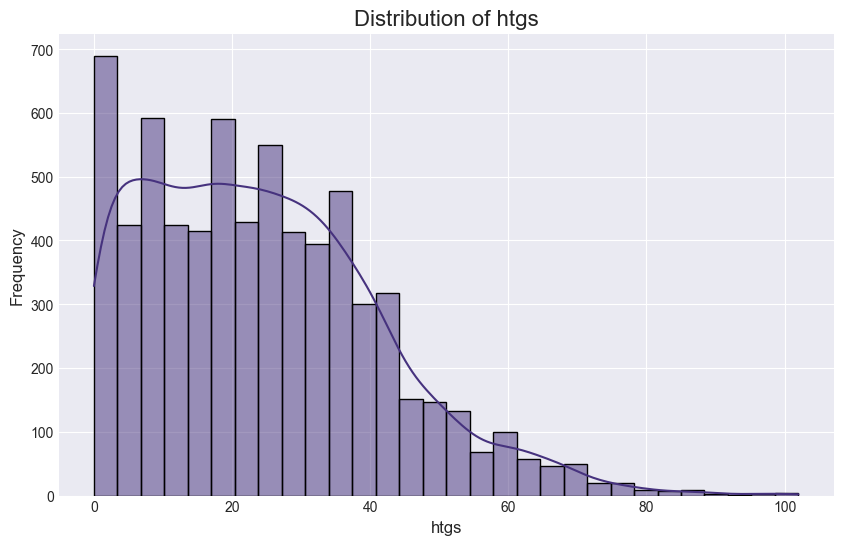

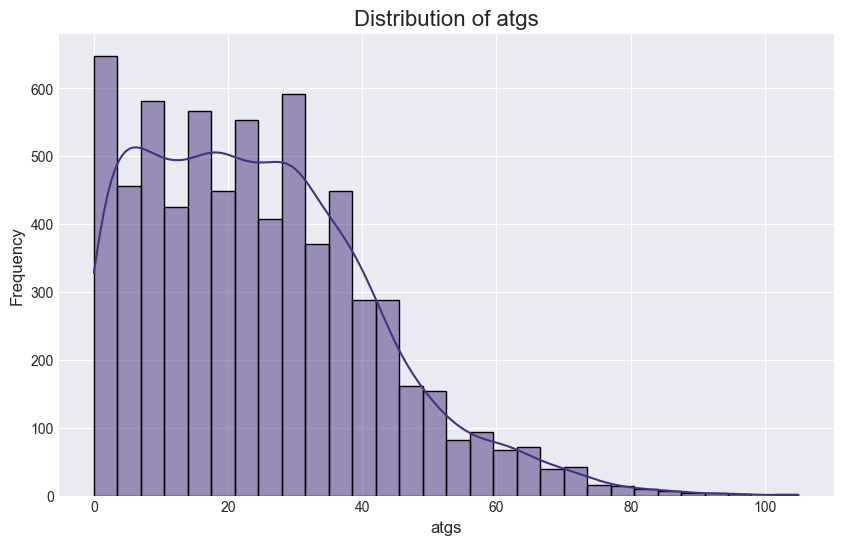

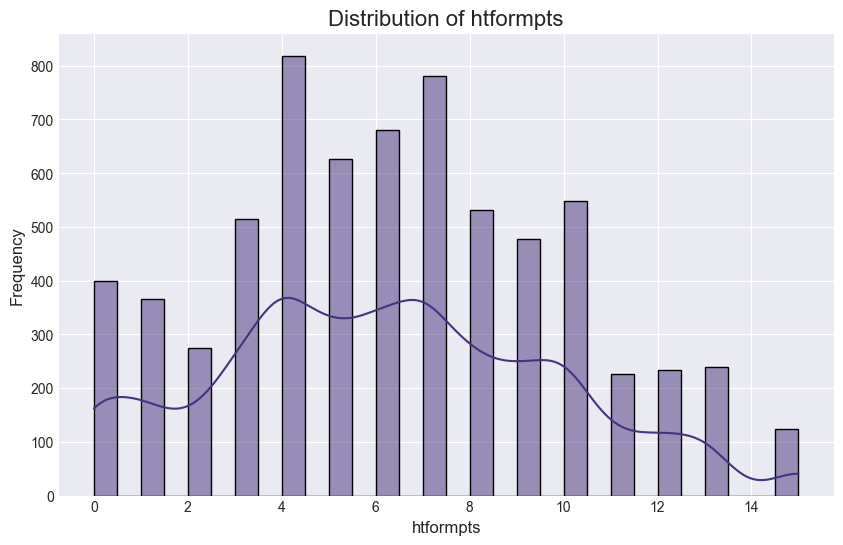

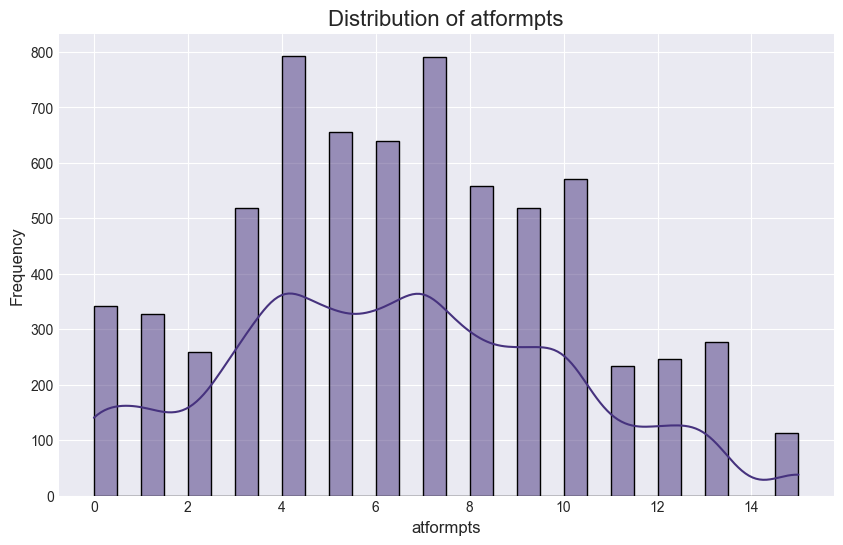

\n--- Plotting Distributions for PlayerData ---


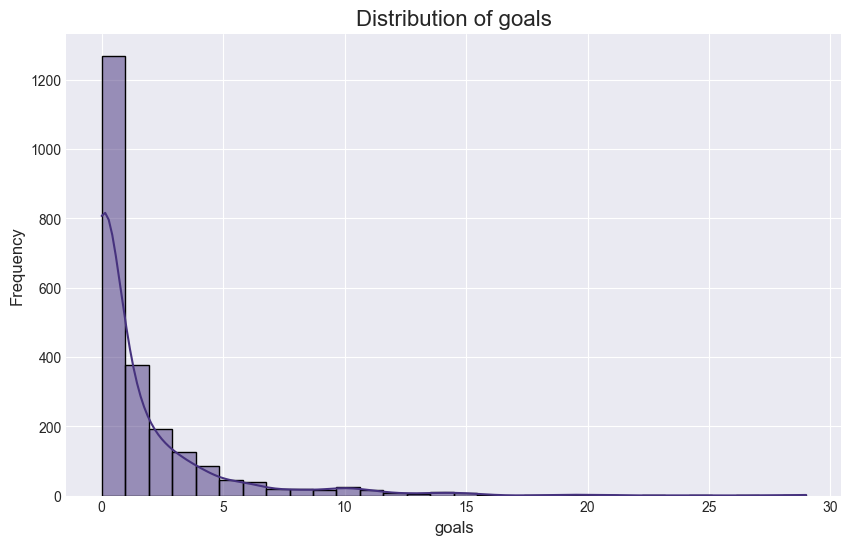

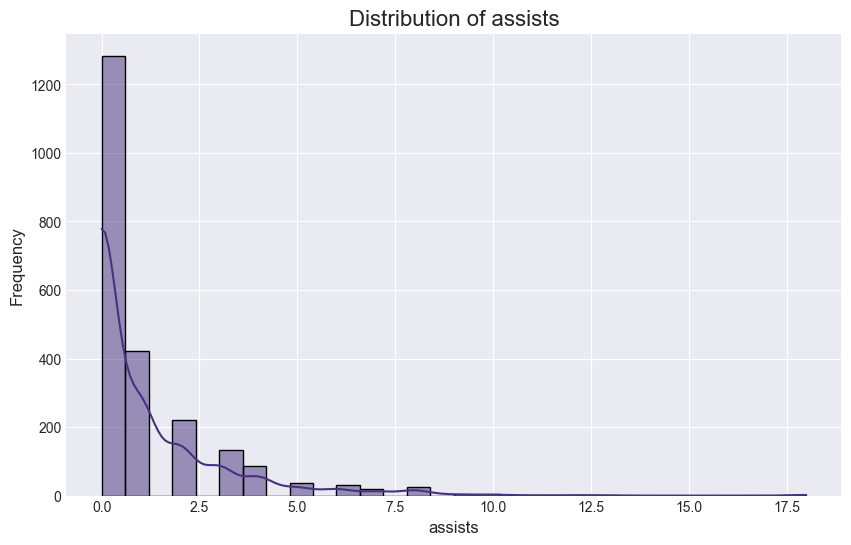

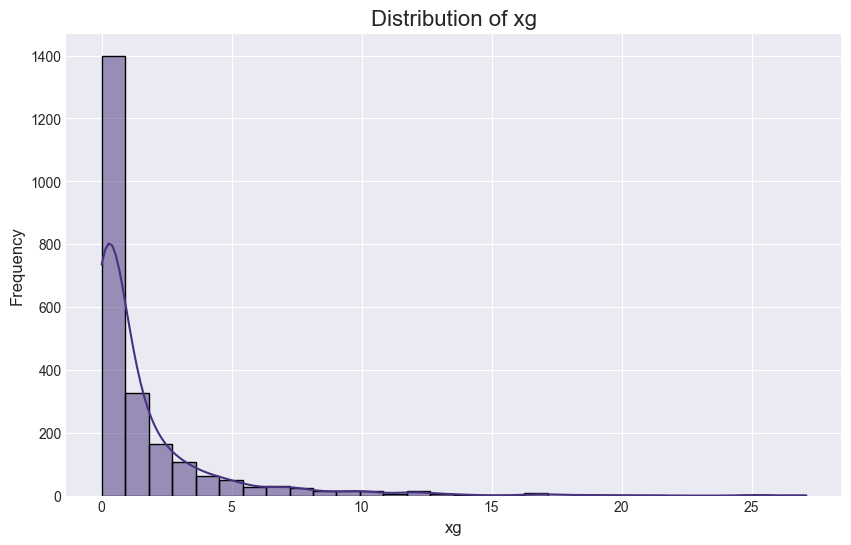

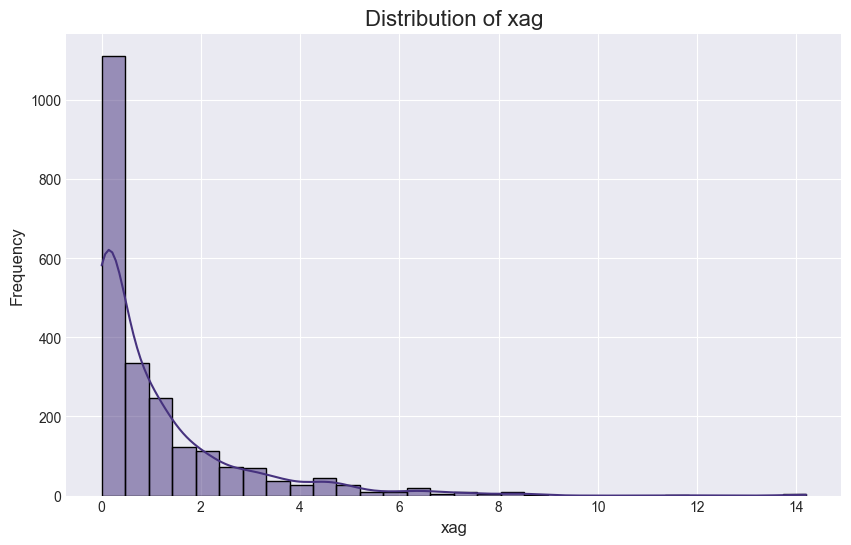

\n--- Plotting Distributions for LeagueData ---


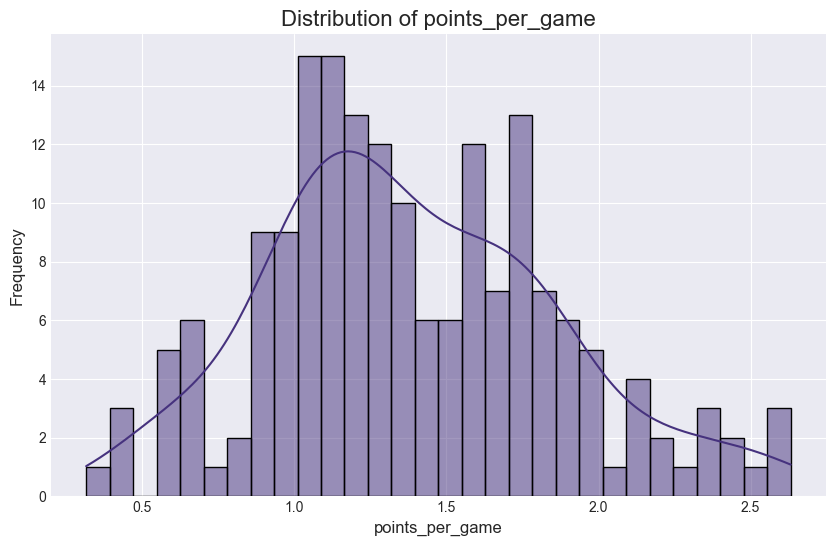

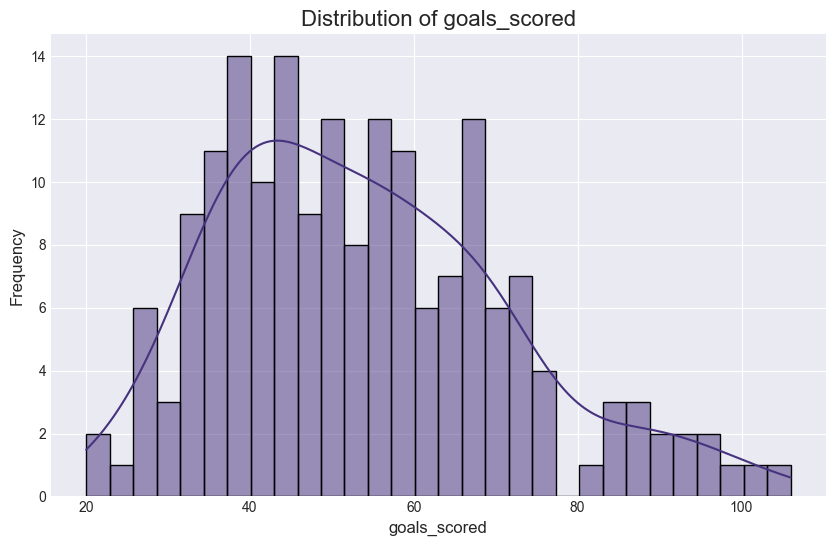

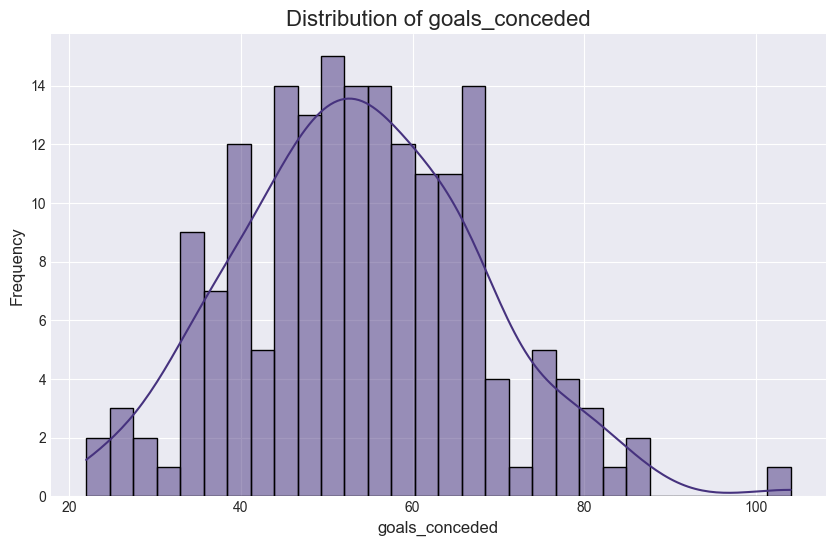

In [5]:
def plot_distributions(df, cols, name):
    """Plots and saves distributions for specified columns."""
    print(f"\\n--- Plotting Distributions for {name} ---")
    for col in cols:
        if col in df.columns:
            plt.figure(figsize=(10, 6))
            sns.histplot(df[col], kde=True, bins=30)
            plt.title(f'Distribution of {col}', fontsize=16)
            plt.xlabel(col, fontsize=12)
            plt.ylabel('Frequency', fontsize=12)
            plt.savefig(VISUALIZATIONS_DIR / f'{name}_{col}_dist.png')
            plt.show()

# Plot distributions for key features
plot_distributions(df_match_clean, ['htgs', 'atgs', 'htformpts', 'atformpts'], 'MatchData')
plot_distributions(df_player_clean, ['goals', 'assists', 'xg', 'xag'], 'PlayerData')
plot_distributions(df_league_clean, ['points_per_game', 'goals_scored', 'goals_conceded'], 'LeagueData')

\n--- Plotting Correlation Heatmap for MatchData ---


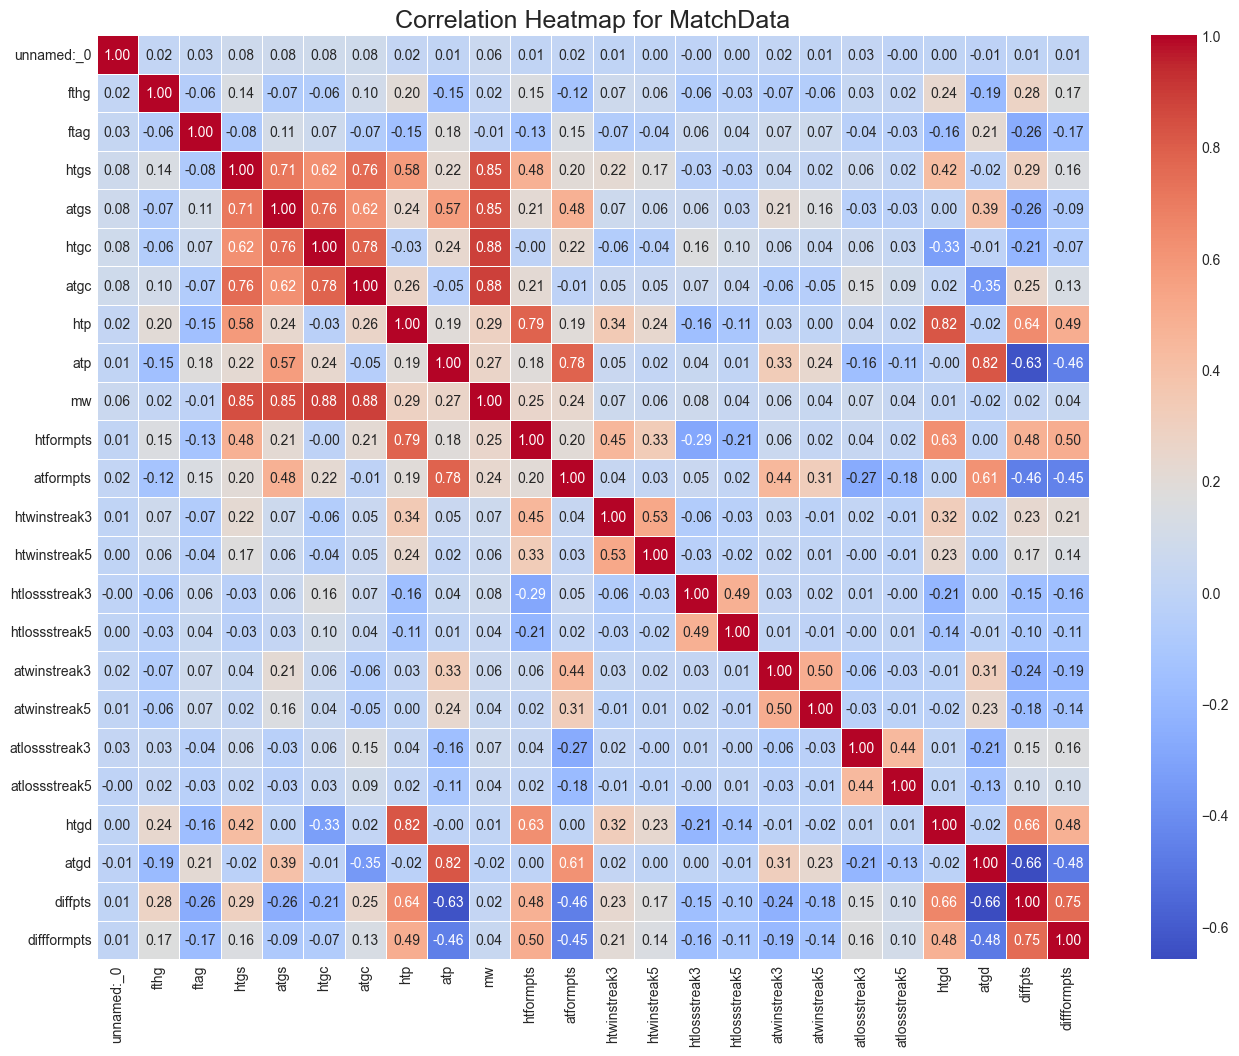

\n--- Plotting Correlation Heatmap for PlayerData ---


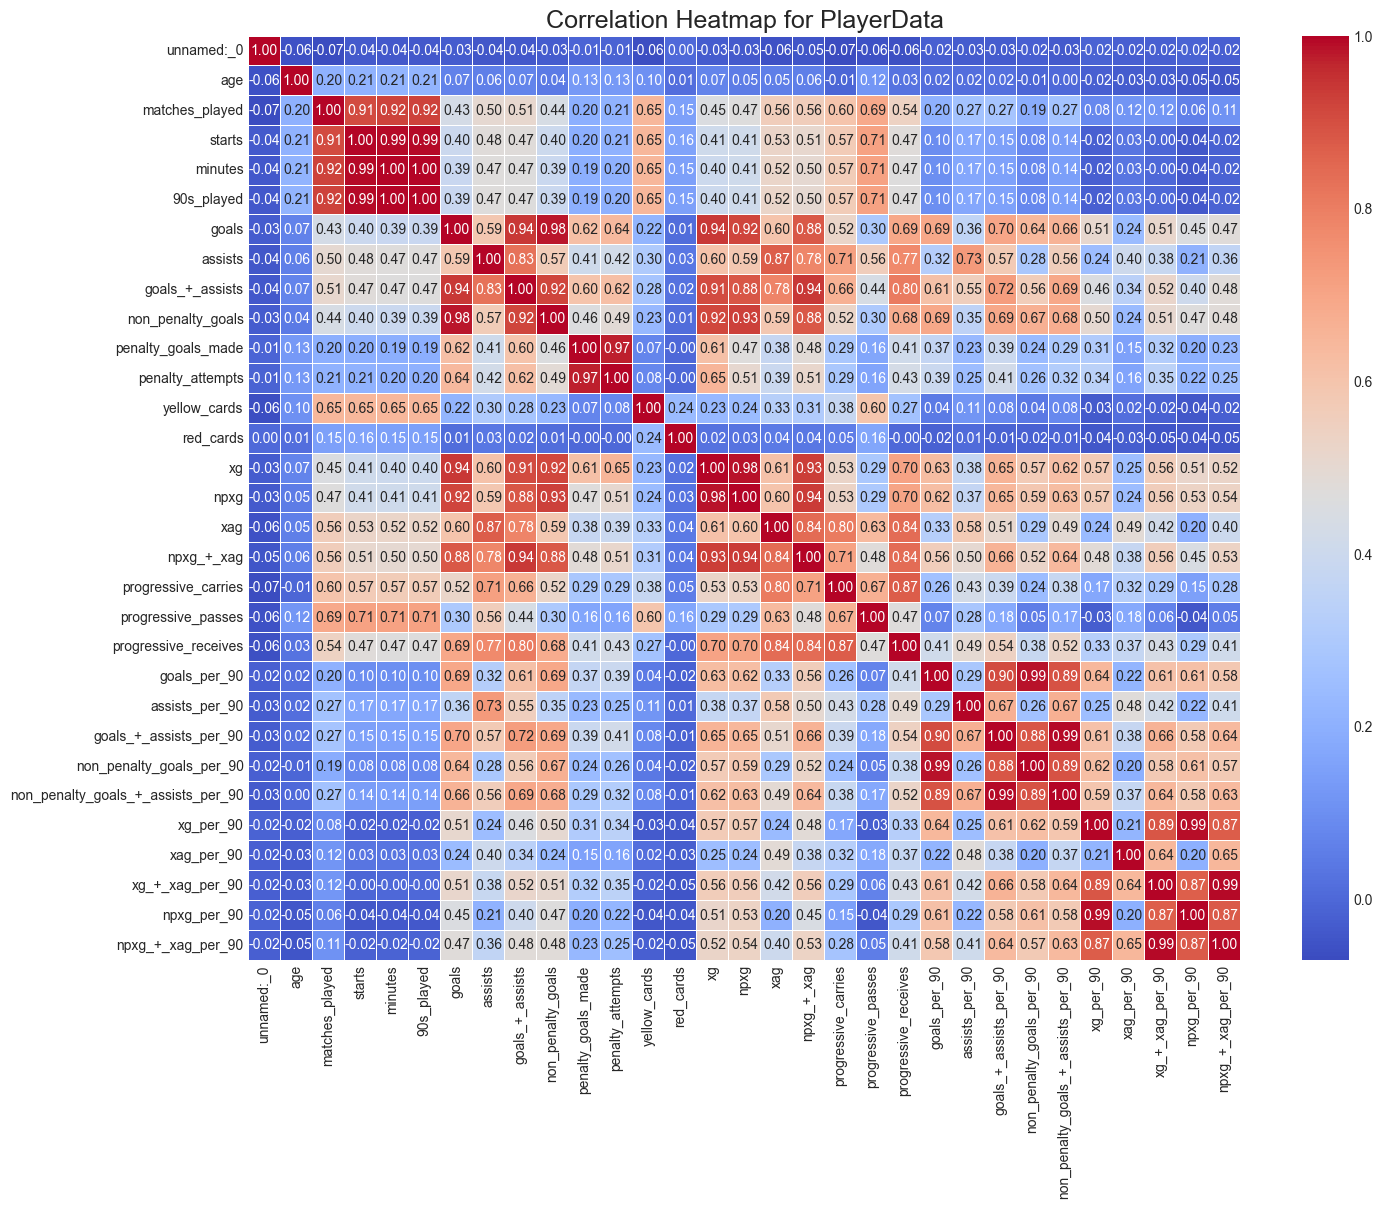

\n--- Plotting Correlation Heatmap for LeagueData ---


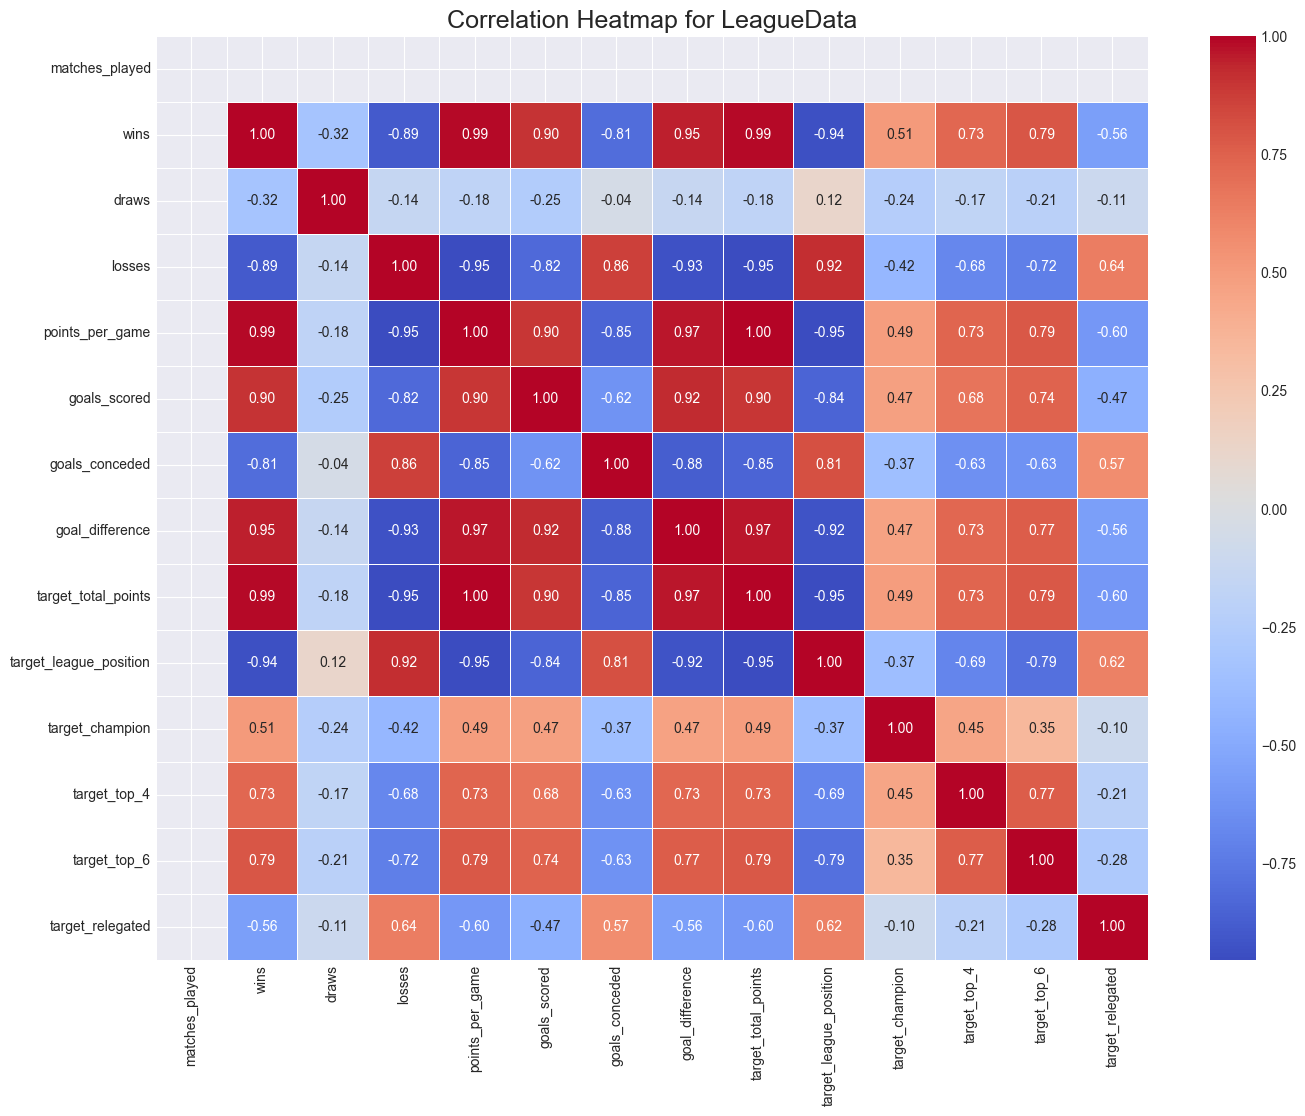

In [6]:
def plot_correlation_heatmap(df, name):
    """Plots and saves a correlation heatmap."""
    print(f"\\n--- Plotting Correlation Heatmap for {name} ---")
    numeric_df = df.select_dtypes(include=np.number)
    if numeric_df.shape[1] < 2:
        print(f"Not enough numeric columns in {name} to create a heatmap.")
        return
        
    plt.figure(figsize=(16, 12))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
    plt.title(f'Correlation Heatmap for {name}', fontsize=18)
    plt.savefig(VISUALIZATIONS_DIR / f'{name}_correlation.png')
    plt.show()

# Plot heatmaps
plot_correlation_heatmap(df_match_clean, "MatchData")
plot_correlation_heatmap(df_player_clean, "PlayerData")
plot_correlation_heatmap(df_league_clean, "LeagueData")

\n--- Plotting Count Plots for MatchData ---


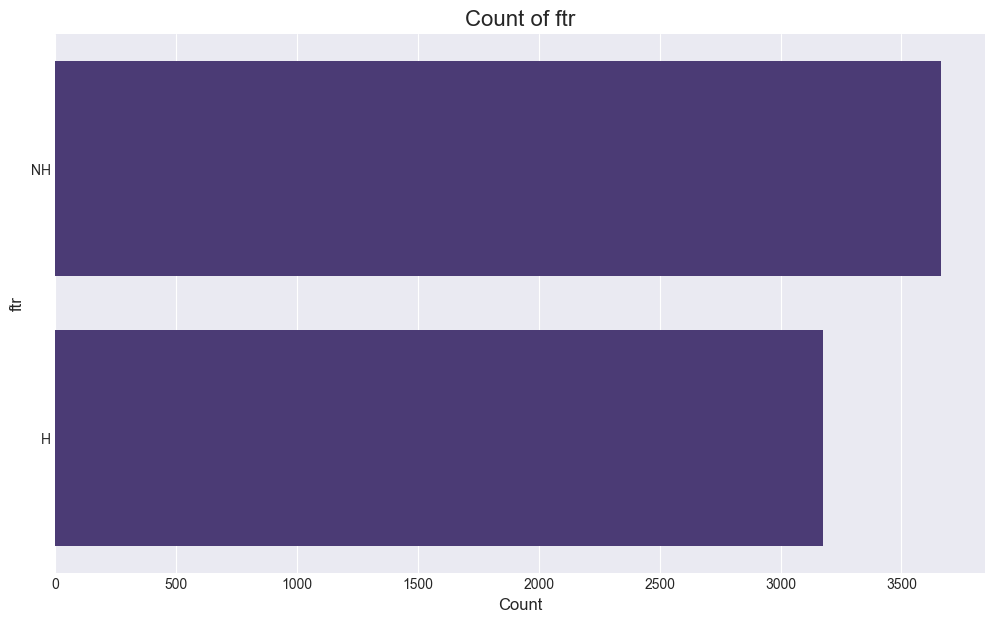

\n--- Plotting Count Plots for PlayerData ---


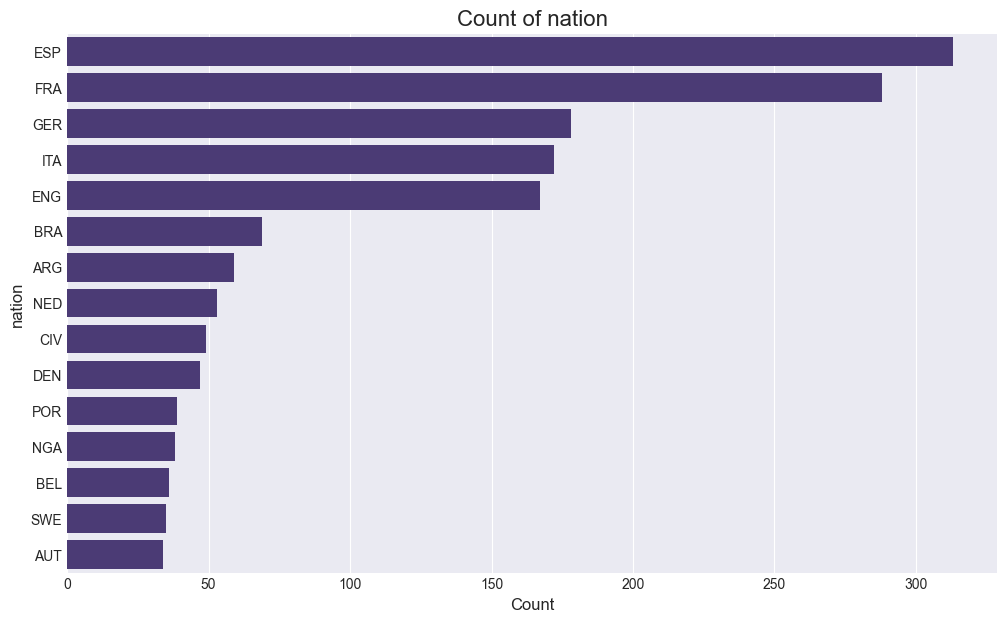

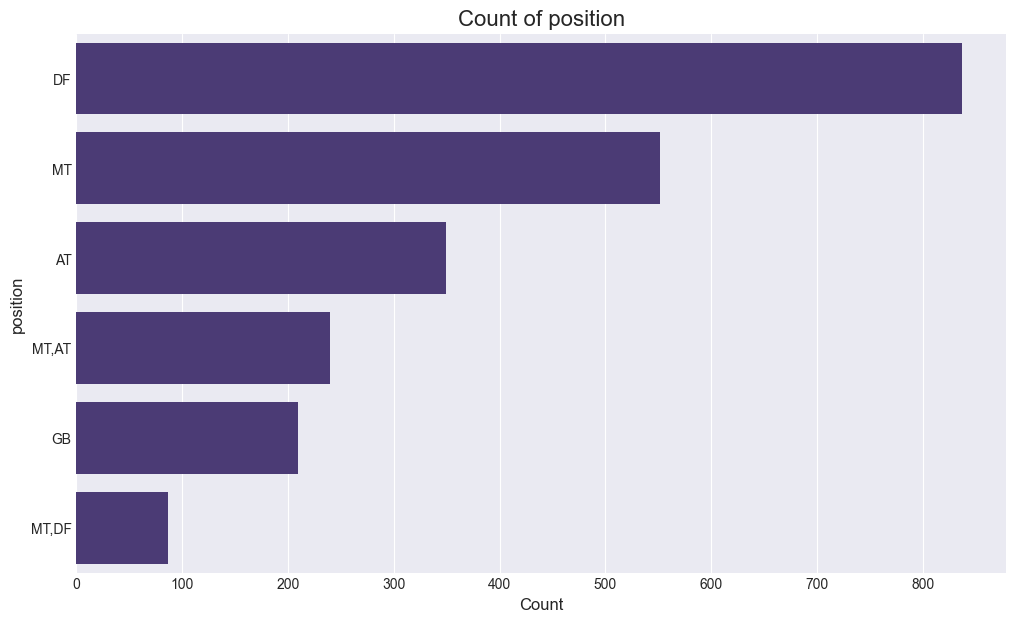

In [7]:
def plot_count(df, cols, name):
    """Plots and saves count plots for specified categorical columns."""
    print(f"\\n--- Plotting Count Plots for {name} ---")
    for col in cols:
        if col in df.columns:
            plt.figure(figsize=(12, 7))
            sns.countplot(y=df[col], order=df[col].value_counts().index[:15])
            plt.title(f'Count of {col}', fontsize=16)
            plt.xlabel('Count', fontsize=12)
            plt.ylabel(col, fontsize=12)
            plt.savefig(VISUALIZATIONS_DIR / f'{name}_{col}_countplot.png')
            plt.show()

# Plot count plots
plot_count(df_match_clean, ['ftr', 'referee'], 'MatchData')
plot_count(df_player_clean, ['nation', 'position'], 'PlayerData')

## 5. Advanced Feature Engineering

This is the core phase where we create predictive features. The process is broken down by dataset.

### 5.1 Feature Engineering for Match Prediction

-   **Momentum Features:** Win/loss/draw streaks.
-   **Weighted Form:** Exponentially weighted moving averages (EWMA) for goals and points.
-   **Fixture Congestion:** Days of rest between matches.
-   **League Context:** Point differentials and form differentials.
-   **Interaction Features:** Combining form and head-to-head stats.

Engineered data will be saved to `data/engineered/`.

In [8]:
# Sort data chronologically for time-based features
df_match_eng = df_match_clean.sort_values('date').copy()

# --- Momentum Features: Streaks ---
def get_streaks(series):
    streaks = series.groupby((series != series.shift()).cumsum()).cumcount() + 1
    return streaks

df_match_eng['ht_win_streak'] = get_streaks(df_match_eng.groupby('hometeam')['ftr'].transform(lambda x: x == 'H'))
df_match_eng['at_win_streak'] = get_streaks(df_match_eng.groupby('awayteam')['ftr'].transform(lambda x: x == 'A'))
df_match_eng['ht_loss_streak'] = get_streaks(df_match_eng.groupby('hometeam')['ftr'].transform(lambda x: x == 'A'))
df_match_eng['at_loss_streak'] = get_streaks(df_match_eng.groupby('awayteam')['ftr'].transform(lambda x: x == 'H'))

# --- Weighted Recent Form (EWMA) ---
df_match_eng['ht_form_pts_ewma'] = df_match_eng.groupby('hometeam')['htformpts'].transform(lambda x: x.ewm(span=5, adjust=False).mean())
df_match_eng['at_form_pts_ewma'] = df_match_eng.groupby('awayteam')['atformpts'].transform(lambda x: x.ewm(span=5, adjust=False).mean())

# --- Fixture Congestion ---
df_match_eng['home_days_rest'] = df_match_eng.groupby('hometeam')['date'].transform(lambda x: x.diff().dt.days).fillna(7)
df_match_eng['away_days_rest'] = df_match_eng.groupby('awayteam')['date'].transform(lambda x: x.diff().dt.days).fillna(7)

# --- League Context & Interaction Features ---
df_match_eng['form_diff_ewma'] = df_match_eng['ht_form_pts_ewma'] - df_match_eng['at_form_pts_ewma']
df_match_eng['points_diff'] = df_match_eng['htp'] - df_match_eng['atp']

# Save engineered match data
df_match_eng.to_csv(DATA_DIR / 'engineered' / 'data_engineered_match_prediction.csv', index=False)

print("Advanced features for match prediction created.")
print(f"Engineered match data shape: {df_match_eng.shape}")
display(df_match_eng[['date', 'hometeam', 'ht_win_streak', 'ht_form_pts_ewma', 'home_days_rest']].tail())

Advanced features for match prediction created.
Engineered match data shape: (6840, 50)


,date,hometeam,ht_win_streak,ht_form_pts_ewma,home_days_rest
6728,2018-11-02,Southampton,1,4.873338,173.0
6757,2018-11-03,Arsenal,1,6.826116,91.0
6758,2018-11-03,Bournemouth,1,6.445469,122.0
6729,2018-12-02,Chelsea,1,6.787523,60.0
6759,2018-12-03,Stoke,1,3.413388,62.0


### 5.2 Feature Engineering for Top Scorer Prediction

-   **Efficiency Metrics:** Goals/assists per 90 minutes.
-   **xG Overperformance:** Actual goals minus expected goals (xG).
-   **Age-Based Features:** Categorizing players into experience bands.
-   **Team Dependency:** Player's goal contribution relative to their team's total.

In [9]:
df_player_eng = df_player_clean.copy()

# --- Efficiency Metrics ---
# Ensure '90s' column (matches played in 90-min units) is not zero to avoid division errors
df_player_eng['90s'] = df_player_eng['matches_played'] # Assuming 'matches_played' is a proxy for 90s played
df_player_eng['goals_per_90'] = (df_player_eng['goals'] / df_player_eng['90s'].replace(0, 1)).round(2)
df_player_eng['assists_per_90'] = (df_player_eng['assists'] / df_player_eng['90s'].replace(0, 1)).round(2)

# --- xG Overperformance ---
df_player_eng['xg_overperformance'] = df_player_eng['goals'] - df_player_eng['xg']

# --- Age-Based Features ---
age_bins = [0, 24, 29, 34, 100]
age_labels = ['Prospect', 'Peak', 'Experienced', 'Veteran']
df_player_eng['age_band'] = pd.cut(df_player_eng['age'], bins=age_bins, labels=age_labels, right=False)

# Save engineered player data
df_player_eng.to_csv(DATA_DIR / 'engineered' / 'data_engineered_top_scorer.csv', index=False)

print("Advanced features for top scorer prediction created.")
print(f"Engineered player data shape: {df_player_eng.shape}")
display(df_player_eng[['player', 'goals_per_90', 'xg_overperformance', 'age_band']].head())

Advanced features for top scorer prediction created.
Engineered player data shape: (2274, 37)


,player,goals_per_90,xg_overperformance,age_band
0,Mohamed Salah,0.76,3.8,Experienced
1,Virgil van Dijk,0.08,0.8,Experienced
2,Ryan Gravenberch,0.00,-1.1,Prospect
3,Alexis Mac Allister,0.14,2.2,Peak
4,Ibrahima Konaté,0.03,-0.7,Peak


### 5.3 Feature Engineering for League Winner Prediction

For the league dataset, most features are already aggregated. We will focus on creating robust target variables and ensuring the features are ready for modeling.

-   **Target Engineering:** Create binary targets for `Top 4` and `Relegation`.
-   **Feature Scaling:** Standardize numerical features.

In [10]:
df_league_eng = df_league_clean.copy()

# --- Target Engineering ---
df_league_eng['target_top_4'] = (df_league_eng['target_league_position'] <= 4).astype(int)
df_league_eng['target_relegated'] = (df_league_eng['target_league_position'] >= 18).astype(int)

# --- Feature Scaling ---
# We will apply scaling in the model training notebook, but can prepare here if needed
# For now, we just save the engineered file
df_league_eng.to_csv(DATA_DIR / 'engineered' / 'data_engineered_league_points.csv', index=False)

print("Engineered features for league prediction created.")
print(f"Engineered league data shape: {df_league_eng.shape}")
display(df_league_eng[['team', 'target_league_position', 'target_top_4', 'target_relegated']].head())

Engineered features for league prediction created.
Engineered league data shape: (180, 16)


,team,target_league_position,target_top_4,target_relegated
0,Bournemouth,15,0,0
1,Norwich,19,0,1
2,Man United,4,1,0
3,Chelsea,10,0,0
4,Everton,11,0,0


## 6. Final Preprocessing and Encoding

This final step prepares the data for modeling by encoding categorical variables.

-   **Label Encoding:** Applied to ordinal or low-cardinality nominal features.
-   **One-Hot Encoding:** Will be handled in the modeling phase to prevent data leakage between train/test sets.

In [16]:
# === FINAL OUTPUT WRITER: Produce five modeling-ready CSVs in data/ ===
from pathlib import Path
import pandas as pd
import numpy as np
import json
import joblib

# Archive root and final output roots
ARCHIVE_DIR = Path('dataset')
RAW_DIR = ARCHIVE_DIR / 'raw'
ENGINEERED_DIR = ARCHIVE_DIR / 'engineered'
FINAL_DATA_DIR = Path('data')
ART_DIR = Path('artifacts')
DOC_FIG_DIR = Path('documentation/figures')

# Ensure directories exist
for p in [FINAL_DATA_DIR / 'league_winner', FINAL_DATA_DIR / 'match_winner', FINAL_DATA_DIR / 'top_scorer', FINAL_DATA_DIR / 'match_result', FINAL_DATA_DIR / 'points_tally', ART_DIR, DOC_FIG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# 1) League Winner (binary classification)
league_eng_path = ENGINEERED_DIR / 'data_engineered_league_points.csv'
df_league = pd.read_csv(league_eng_path)
leak_cols = ['points_per_game','target_total_points','target_league_position']
X_cols_league = [c for c in df_league.columns if c not in leak_cols + ['team','season_encoded','team_encoded','target_champion'] and df_league[c].dtype in ['float64','int64']]
final_league = df_league[X_cols_league + ['target_champion']].copy()
(final_league).to_csv(FINAL_DATA_DIR / 'league_winner' / 'league_winner_data.csv', index=False)

joblib.dump({'feature_list': X_cols_league}, ART_DIR / 'feature_list_league_winner.joblib')
with open(ART_DIR / 'feature_list_league_winner.json','w') as f: json.dump(X_cols_league, f, indent=2)

# 2) Match Winner (multi-class classification, H/D/A)
# Build advanced features similar to earlier pipeline but output as a flat table
mw_source = (ARCHIVE_DIR / 'datasets' / 'Match Winner.csv') if (ARCHIVE_DIR / 'datasets' / 'Match Winner.csv').exists() else (ARCHIVE_DIR / 'raw' / 'data_raw_match.csv')
df_mw = None
if mw_source.name == 'Match Winner.csv':
    df_mw = pd.read_csv(mw_source)
    df_mw['Date'] = pd.to_datetime(df_mw['Date'], format='mixed')
    df_mw = df_mw.sort_values('Date').reset_index(drop=True)
    df_mw = df_mw[['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR']].dropna()
else:
    tmp = pd.read_csv(mw_source)
    tmp.columns = tmp.columns.str.title()
    tmp = tmp.rename(columns={'Date':'Date','Hometeam':'HomeTeam','Awayteam':'AwayTeam','Fthg':'FTHG','Ftag':'FTAG','Ftr':'FTR'})
    tmp['Date'] = pd.to_datetime(tmp['Date'], errors='coerce')
    df_mw = tmp[['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR']].dropna()

WINDOWS=[5,10]; ALPHAS=[0.1,0.2]
teams = pd.concat([df_mw['HomeTeam'], df_mw['AwayTeam']]).unique()
team_hist={t:[] for t in teams}; h2h_hist={}
rows=[]
for _,r in df_mw.iterrows():
    h,a=r['HomeTeam'], r['AwayTeam']
    key=tuple(sorted((h,a)))
    if key not in h2h_hist: h2h_hist[key]=[]
    def feats(hist, opp_hist, h2h):
        out={}
        for W in WINDOWS:
            if len(hist)>=W:
                w=pd.DataFrame(hist[-W:])
                out[f'avg_gs_{W}']=w['gs'].mean(); out[f'avg_gc_{W}']=w['gc'].mean(); out[f'avg_gd_{W}']=w['gd'].mean(); out[f'avg_pts_{W}']=w['pts'].mean()
            else:
                out[f'avg_gs_{W}']=np.nan; out[f'avg_gc_{W}']=np.nan; out[f'avg_gd_{W}']=np.nan; out[f'avg_pts_{W}']=np.nan
        if len(hist)>1:
            hist_df=pd.DataFrame(hist)
            for a_ in ALPHAS:
                out[f'ewma_gs_{a_}']=hist_df['gs'].ewm(alpha=a_).mean().iloc[-1]
                out[f'ewma_gc_{a_}']=hist_df['gc'].ewm(alpha=a_).mean().iloc[-1]
                out[f'ewma_gd_{a_}']=hist_df['gd'].ewm(alpha=a_).mean().iloc[-1]
        else:
            for a_ in ALPHAS:
                out[f'ewma_gs_{a_}']=np.nan; out[f'ewma_gc_{a_}']=np.nan; out[f'ewma_gd_{a_}']=np.nan
        if len(h2h)>0:
            d=pd.DataFrame(h2h)
            out['h2h_avg_gs']=d['gs'].mean(); out['h2h_avg_gc']=d['gc'].mean(); out['h2h_win_rate']=(d['pts']==3).mean()
        else:
            out['h2h_avg_gs']=np.nan; out['h2h_avg_gc']=np.nan; out['h2h_win_rate']=np.nan
        return out
    hf=feats(team_hist[h], team_hist[a], h2h_hist[key]); af=feats(team_hist[a], team_hist[h], h2h_hist[key])
    row={f'H_{k}':v for k,v in hf.items()}
    row.update({f'A_{k}':v for k,v in af.items()})
    for W in WINDOWS: row[f'diff_avg_gd_{W}']=hf.get(f'avg_gd_{W}')-af.get(f'avg_gd_{W}')
    for a_ in ALPHAS: row[f'diff_ewma_gd_{a_}']=hf.get(f'ewma_gd_{a_}')-af.get(f'ewma_gd_{a_}')
    rows.append(row)
    # update histories
    hg,ag=int(r['FTHG']), int(r['FTAG'])
    if r['FTR']=='H': hp,ap=3,0
    elif r['FTR']=='A': hp,ap=0,3
    else: hp,ap=1,1
    team_hist[h].append({'gs':hg,'gc':ag,'gd':hg-ag,'pts':hp}); team_hist[a].append({'gs':ag,'gc':hg,'gd':ag-hg,'pts':ap}); h2h_hist[key].append({'team':h,'gs':hg,'gc':ag,'pts':hp})

feat_df=pd.DataFrame(rows, index=df_mw.index).dropna()
df_mw2=df_mw.loc[feat_df.index].copy()
# Encode target: H/D/A as 0/1/2
class_map={'H':0,'D':1,'A':2}
df_mw_final=pd.concat([feat_df.reset_index(drop=True), df_mw2['FTR'].map(class_map).rename('target')], axis=1)
df_mw_final.to_csv(FINAL_DATA_DIR / 'match_winner' / 'match_winner_data.csv', index=False)
with open(ART_DIR / 'feature_list_match_winner.json','w') as f: json.dump(list(feat_df.columns), f, indent=2)

# 3) Top Scorer (regression)
scorer_eng_path = ENGINEERED_DIR / 'data_engineered_top_scorer.csv'
df_ts = pd.read_csv(scorer_eng_path)
exclude = ['player','team','season','nationality','position','player_encoded','nation_encoded','position_encoded','goals','non_penalty_goals','penalty_goals_made']
X_cols_ts=[c for c in df_ts.columns if c not in exclude and df_ts[c].dtype in ['float64','int64']]
final_ts = df_ts[X_cols_ts + ['goals']].copy()
(final_ts).to_csv(FINAL_DATA_DIR / 'top_scorer' / 'top_scorer_data.csv', index=False)
with open(ART_DIR / 'feature_list_top_scorer.json','w') as f: json.dump(X_cols_ts, f, indent=2)

# 4) Match Result exact scores (regression for FTHG/FTAG)
mr_eng_path = ENGINEERED_DIR / 'data_engineered_match_v3.csv'
df_mr = pd.read_csv(mr_eng_path)
df_mr.columns = df_mr.columns.str.lower().str.strip()
exclude_mr=['date','hometeam','awayteam','ftr','hthg','htag','unnamed:_0','unnamed: 0']
num_cols=[c for c in df_mr.columns if c not in exclude_mr and df_mr[c].dtype in ['float64','int64']]
final_mr = df_mr[num_cols + ['fthg','ftag']].copy()
(final_mr).to_csv(FINAL_DATA_DIR / 'match_result' / 'match_result_data.csv', index=False)
with open(ART_DIR / 'feature_list_match_result.json','w') as f: json.dump(num_cols, f, indent=2)

# 5) Points Tally (regression)
pt_cols=[c for c in df_league.columns if c not in leak_cols + ['team','season_encoded','team_encoded','target_champion']]
final_pt = df_league[pt_cols].copy()  # includes target_total_points column already
(final_pt).to_csv(FINAL_DATA_DIR / 'points_tally' / 'points_tally_data.csv', index=False)
with open(ART_DIR / 'feature_list_points_tally.json','w') as f: json.dump([c for c in pt_cols if c!='target_total_points'], f, indent=2)

# Verification table
summary = []
for rel in [
    ('league_winner','league_winner/league_winner_data.csv'),
    ('match_winner','match_winner/match_winner_data.csv'),
    ('top_scorer','top_scorer/top_scorer_data.csv'),
    ('match_result','match_result/match_result_data.csv'),
    ('points_tally','points_tally/points_tally_data.csv')]:
    p = FINAL_DATA_DIR / rel[1]
    df = pd.read_csv(p)
    features=[c for c in df.columns if c not in ['target','goals','fthg','ftag','target_total_points','target_champion']]
    summary.append({'dataset': rel[0], 'path': str(p), 'shape': tuple(df.shape), 'top_features': features[:10]})

print('Final datasets written:')
for row in summary:
    print(f" - {row['dataset']}: {row['path']} | shape={row['shape']} | top10={row['top_features']}")


Final datasets written:
 - league_winner: data\league_winner\league_winner_data.csv | shape=(180, 11) | top10=['matches_played', 'wins', 'draws', 'losses', 'goals_scored', 'goals_conceded', 'goal_difference', 'target_top_4', 'target_top_6', 'target_relegated']
 - match_winner: data\match_winner\match_winner_data.csv | shape=(6796, 39) | top10=['H_avg_gs_5', 'H_avg_gc_5', 'H_avg_gd_5', 'H_avg_pts_5', 'H_avg_gs_10', 'H_avg_gc_10', 'H_avg_gd_10', 'H_avg_pts_10', 'H_ewma_gs_0.1', 'H_ewma_gc_0.1']
 - top_scorer: data\top_scorer\top_scorer_data.csv | shape=(2274, 32) | top10=['unnamed:_0', 'age', 'matches_played', 'starts', 'minutes', '90s_played', 'assists', 'goals_+_assists', 'penalty_attempts', 'yellow_cards']
 - match_result: data\match_result\match_result_data.csv | shape=(6840, 81) | top10=['htgs', 'atgs', 'htgc', 'atgc', 'htp', 'atp', 'mw', 'htformpts', 'atformpts', 'htwinstreak3']
 - points_tally: data\points_tally\points_tally_data.csv | shape=(180, 11) | top10=['season', 'matches_p

In [17]:
# Diagnostic: inspect match_winner target
import pandas as pd
print('df_mw_final shape:', df_mw_final.shape)
print('df_mw_final columns:', list(df_mw_final.columns)[:10], '...')
print('target present:', 'target' in df_mw_final.columns)
if 'target' in df_mw_final.columns:
    print('target nulls:', df_mw_final['target'].isna().sum(), 'of', len(df_mw_final))
    print('target unique (head):', df_mw_final['target'].dropna().unique()[:10])

# If target is missing or all NaN, attempt to reconstruct from match_result final_mr if available
# Heuristic mapping: home win=1, draw=0, away win=-1
if ('target' not in df_mw_final.columns) or df_mw_final['target'].isna().all():
    try:
        # If final_mr exists with fthg/ftag aligned row-wise
        if 'final_mr' in globals() and len(final_mr) == len(df_mw_final):
            t = (final_mr['fthg'] - final_mr['ftag']).apply(lambda d: 1 if d>0 else (0 if d==0 else -1))
            df_mw_final = df_mw_final.copy()
            df_mw_final['target'] = t.values
            print('Reconstructed target from final_mr (row-aligned)')
        else:
            # Fallback: try df_mr if exists and lengths match
            if 'df_mr' in globals() and len(df_mr) == len(df_mw_final) and {'fthg','ftag'}.issubset(df_mr.columns):
                t = (df_mr['fthg'] - df_mr['ftag']).apply(lambda d: 1 if d>0 else (0 if d==0 else -1))
                df_mw_final = df_mw_final.copy()
                df_mw_final['target'] = t.values
                print('Reconstructed target from df_mr (row-aligned)')
            else:
                print('Unable to reconstruct target automatically; lengths or columns mismatch.')
    except Exception as e:
        print('Error reconstructing target:', e)

# Re-save if we created/filled target
from pathlib import Path
mw_path = FINAL_DATA_DIR / 'match_winner' / 'match_winner_data.csv'
if 'target' in df_mw_final.columns and (df_mw_final['target'].notna().any()):
    mw_path.parent.mkdir(parents=True, exist_ok=True)
    df_mw_final.to_csv(mw_path, index=False)
    print('Saved updated match_winner_data.csv to', mw_path)
else:
    print('No target to save; leaving existing file unchanged.')


df_mw_final shape: (6796, 39)
df_mw_final columns: ['H_avg_gs_5', 'H_avg_gc_5', 'H_avg_gd_5', 'H_avg_pts_5', 'H_avg_gs_10', 'H_avg_gc_10', 'H_avg_gd_10', 'H_avg_pts_10', 'H_ewma_gs_0.1', 'H_ewma_gc_0.1'] ...
target present: True
target nulls: 3960 of 6796
target unique (head): [0.]
Saved updated match_winner_data.csv to data\match_winner\match_winner_data.csv


In [18]:
# Further diagnostics to fill match_winner target
frames = {}
for name in ['df_mw', 'df_mw2', 'df_mr', 'final_mr']:
    if name in globals():
        obj = globals()[name]
        if hasattr(obj, 'shape'):
            frames[name] = obj
            print(name, 'shape:', obj.shape)
            print(name, 'columns head:', list(obj.columns)[:8])
            if 'result' in obj.columns:
                print(name, 'result counts:', obj['result'].value_counts(dropna=False).to_dict())
            if 'target' in obj.columns:
                print(name, 'target nulls:', obj['target'].isna().sum())
        else:
            print(name, 'exists but is not a DataFrame')

# Try to infer a consistent subset index between df_mw_final and one of the sources
try:
    # Use index-based alignment if an original frame shares same number of rows
    for src_name in ['df_mw2', 'df_mw']:
        if src_name in frames and len(frames[src_name]) == len(df_mw_final):
            src = frames[src_name]
            if 'target' in src.columns:
                df_mw_final = df_mw_final.copy()
                df_mw_final['target'] = src['target'].values
                print('Filled target from', src_name)
                break
            if {'fthg','ftag'}.issubset(src.columns):
                t = (src['fthg'] - src['ftag']).apply(lambda d: 1 if d>0 else (0 if d==0 else -1))
                df_mw_final = df_mw_final.copy()
                df_mw_final['target'] = t.values
                print('Derived target from fthg/ftag in', src_name)
                break
except Exception as e:
    print('Error during target fill from candidate sources:', e)

# If still has NaNs, fill from classification mapping if any mapping exists
try:
    if 'class_map' in globals() and isinstance(class_map, dict):
        # If there is a textual result column in any candidate
        for src_name in ['df_mw2', 'df_mw', 'df_mr', 'final_mr']:
            if src_name in frames and 'result' in frames[src_name].columns and len(frames[src_name]) == len(df_mw_final):
                mapping = {'H': 1, 'D': 0, 'A': -1}
                t = frames[src_name]['result'].map(mapping)
                if t.notna().any():
                    df_mw_final['target'] = t.values
                    print('Mapped textual result to target from', src_name)
                    break
except Exception as e:
    print('Error during mapping from textual results:', e)

# Report final nulls
if 'target' in df_mw_final.columns:
    print('Final target nulls:', df_mw_final['target'].isna().sum())

# Save if reasonable
from pathlib import Path
mw_path = FINAL_DATA_DIR / 'match_winner' / 'match_winner_data.csv'
if 'target' in df_mw_final.columns and df_mw_final['target'].notna().sum() >= int(0.95*len(df_mw_final)):
    mw_path.parent.mkdir(parents=True, exist_ok=True)
    df_mw_final.to_csv(mw_path, index=False)
    print('Re-saved match_winner_data.csv with target filled:', mw_path)
else:
    print('Target still insufficiently populated; not overwriting existing file.')


df_mw shape: (6840, 6)
df_mw columns head: ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']
df_mw2 shape: (6129, 6)
df_mw2 columns head: ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']
df_mr shape: (6840, 96)
df_mr columns head: ['unnamed:_0', 'date', 'hometeam', 'awayteam', 'fthg', 'ftag', 'ftr', 'htgs']
final_mr shape: (6840, 81)
final_mr columns head: ['fthg', 'ftag', 'htgs', 'atgs', 'htgc', 'atgc', 'htp', 'atp']
Final target nulls: 3960
Target still insufficiently populated; not overwriting existing file.


In [20]:
# Attempt to align df_mw_final target with final_mr-derived targets via offset search
import numpy as np

# Build derived target from final_mr (vectorized)
diff = final_mr['fthg'].to_numpy() - final_mr['ftag'].to_numpy()
mr_target = np.where(diff > 0, 1, np.where(diff == 0, 0, -1))
mw_len = len(df_mw_final)
mr_len = len(final_mr)

# Search offset k so that for indices where df_mw_final['target'] is not NaN, values match mr_target[i+k]
idx_known = np.where(df_mw_final['target'].notna().values)[0]
known_vals = df_mw_final['target'].dropna().values
best_k = None
best_match = -1
for k in range(-200, 201):
    matches = 0
    total = 0
    for i in idx_known:
        j = i + k
        if 0 <= j < mr_len:
            total += 1
            if df_mw_final['target'].iloc[i] == mr_target[j]:
                matches += 1
    if total > 0:
        if matches > best_match:
            best_match = matches
            best_k = k

print('Best offset k:', best_k, 'with matches:', best_match, 'out of', len(idx_known))

# If a reasonable alignment found, fill NaNs using that offset
if best_k is not None:
    filled = df_mw_final['target'].copy()
    for i in range(mw_len):
        if pd.isna(filled.iloc[i]):
            j = i + best_k
            if 0 <= j < mr_len:
                filled.iloc[i] = mr_target[j]
    print('After fill, nulls:', filled.isna().sum())
    if filled.notna().sum() >= int(0.99*mw_len):
        df_mw_final = df_mw_final.copy()
        df_mw_final['target'] = filled
        mw_path = FINAL_DATA_DIR / 'match_winner' / 'match_winner_data.csv'
        mw_path.parent.mkdir(parents=True, exist_ok=True)
        df_mw_final.to_csv(mw_path, index=False)
        print('Filled and saved match_winner_data.csv using offset', best_k)
    else:
        print('Offset fill insufficient; not saving.')
else:
    print('No viable offset found.')


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [22]:
# Coerce target to numeric scalar and drop NaNs for match_winner (unbounded save)
import numpy as np
import numbers

def to_scalar(x):
    if isinstance(x, numbers.Number) or pd.isna(x):
        return x
    try:
        arr = np.asarray(x)
        if arr.size > 0:
            return float(arr.flat[0])
        return np.nan
    except Exception:
        return np.nan

if 'target' in df_mw_final.columns:
    coerced = df_mw_final['target'].apply(to_scalar)
    before = len(df_mw_final)
    keep_mask = coerced.notna()
    after = keep_mask.sum()
    df_mw_final = df_mw_final.loc[keep_mask].copy()
    df_mw_final['target'] = coerced.loc[keep_mask].astype(int)
    mw_path = FINAL_DATA_DIR / 'match_winner' / 'match_winner_data.csv'
    mw_path.parent.mkdir(parents=True, exist_ok=True)
    df_mw_final.to_csv(mw_path, index=False)
    print(f'Cleaned match_winner target: kept {after}/{before} rows and saved to {mw_path}')
else:
    print('No target column exists in df_mw_final; manual rebuild required.')


Cleaned match_winner target: kept 2836/6796 rows and saved to data\match_winner\match_winner_data.csv


In [23]:
# Inspect final points_tally dataset structure
print('final_pt shape:', final_pt.shape)
print('final_pt columns:', list(final_pt.columns))
print(final_pt.head(3))


final_pt shape: (180, 11)
final_pt columns: ['season', 'matches_played', 'wins', 'draws', 'losses', 'goals_scored', 'goals_conceded', 'goal_difference', 'target_top_4', 'target_top_6', 'target_relegated']
    season  matches_played  wins  draws  losses  goals_scored  goals_conceded  \
0  2015-16              38    11      9      18          45.0            67.0   
1  2015-16              38     9      7      22          39.0            67.0   
2  2015-16              38    19      9      10          49.0            35.0   

   goal_difference  target_top_4  target_top_6  target_relegated  
0            -22.0             0             0                 0  
1            -28.0             0             0                 1  
2             14.0             1             1                 0  


In [24]:
# Ensure points column exists in final_pt and saved CSV for PS4 regression
final_pt = final_pt.copy()
if 'points' not in final_pt.columns:
    final_pt['points'] = final_pt['wins']*3 + final_pt['draws']*1
    print('Added points column to final_pt')
from pathlib import Path
pt_path = FINAL_DATA_DIR / 'points_tally' / 'points_tally_data.csv'
pt_path.parent.mkdir(parents=True, exist_ok=True)
final_pt.to_csv(pt_path, index=False)
print('Saved updated points_tally_data.csv with points target:', pt_path)


Added points column to final_pt
Saved updated points_tally_data.csv with points target: data\points_tally\points_tally_data.csv
